R is of shape
(90, 90)
no data model. Assuming data is given by real experiment or other external source
checking factorization of model ...
... factorization (locally) describes directed acyclic graph


"\n\ndata = np.loadtxt('/home/mackelab/Desktop/Projects/Stitching/data/ChaLearn_Challenge_Connectomics/' \n                 +'valid/fluorescence_valid.txt',\n                   delimiter=',')\n#                + 'fluorescence_iNet1_Size100_CC05inh.txt', \n\ny = np.zeros([data.shape[1], data.shape[0], 1])\ny[:,:,0] = data.transpose()\nyDim  = y.shape[0]\nT     = y.shape[1]\nTrial = y.shape[2]\nuDim  = 0\nu     = []\nx     = []\nifDataGeneratedWithInput = False\nifInputPiecewiseConstant = False\nconstantInputLength = 1\n\n[A,B,Q,mu0,V0,C,d,R,Ext_true,Extxt_true,Extxtm1_true,LLtr]= [0,0,0,0,0,0,0,0,0,0,0,0]\nPi           = np.zeros([xDim, xDim])\nPi_t         = np.zeros([xDim, xDim])\n\nifUseB = False\nsubpops = [list(range(0,yDim)), list(range(0,yDim))]\nobsTime = [int(round(T/4)), int(round(2*T/3)), T]\nobsPops = [0,1,0]\nobsScheme = {'subpops': subpops,\n             'obsTime': obsTime,\n             'obsPops': obsPops}\n[obsIdxG, idxgrps] = ssm_fit._computeObsIndexGroups(obsScheme,yDi

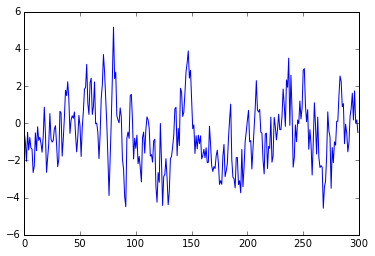

In [5]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import time

import ssm_timeSeries as ts  # my self-written time series overhead
import ssm_fit               # my self-written library for state-space model fitting

from IPython import display  # for live plotting

import random
from datetime import datetime     # generate random seed for 
random.seed(datetime.now())       # np.random. Once this is fixed, all 
rngSeed = random.randint(0, 1000) # other 'randomness' is also fixed

from scipy.io import savemat # store results for comparison with Matlab code


"""  Set latent dimensionality    """

xDim = 10


""" GENERATE SOME ARTIFICIAL DATA """
yDim = 90
T = 100000
Trial = 1

ifUseB = False
subpops = [list(range(0,30)), list(range(20,50)), list(range(40,70)), list(range(60,90))]
obsTime = [int(round(T/4)), int(round(T/2)), int(round(2*T/3)), int(T)]
obsPops = [0,1,2,3]
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}
[obsIdxG, idxgrps] = ssm_fit._computeObsIndexGroups(obsScheme,yDim)
obsScheme['obsIdxG'] = obsIdxG # add index groups and 
obsScheme['idxgrps'] = idxgrps # their occurences        

newDraw = True
if newDraw:
    while True:
        W    = np.random.normal(size=[xDim,xDim])
        if np.abs(np.linalg.det(W)) > 0.001:
            break
    A    = np.diag(np.linspace(0.1,0.95,xDim))  #np.diag(np.random.uniform(size=[xDim]))
    A    = np.dot(np.dot(W, A), np.linalg.inv(W))
    Qnoise = np.random.normal(size=[xDim,xDim])/9
    Qnoise = np.dot(Qnoise, Qnoise.transpose())
    Q    = np.identity(xDim) + Qnoise
    mu0  = np.random.normal(size=[xDim]) #np.random.normal(size=[xDim])
    V0   = np.identity(xDim)
    C = np.random.normal(size=[yDim, xDim])

    Pi    = np.array([sp.linalg.solve_discrete_lyapunov(A, Q)])[0,:,:]
    Pi_t  = np.dot(A.transpose(), Pi)
    CPiC = np.dot(C, np.dot(Pi, C.transpose()))

    R = (0.1 + np.random.uniform(size=[yDim])) * CPiC.diagonal() # set R_ii as 5% to 55% of total variance of y_i
    R = np.diag(R)
    print('R is of shape')
    print(R.shape)
    d  = np.arange(yDim)
    d -= 10
    
    uDim = 1
    B = np.random.normal(size=[xDim,uDim])            
    ifDataGeneratedWithInput = False
    ifInputPiecewiseConstant = True
    constantInputLength = 5000
    u = np.zeros([uDim,T,Trial])
    for tr in range(Trial):
        for i in range(int(np.floor(T/constantInputLength))):
            idxRange = range((i-1)*constantInputLength, i*constantInputLength)
            u[:,idxRange,tr] = np.random.normal(size=[1])
        u[:,:,tr] -= np.mean(u[:,:,tr])
    if not ifUseB:
        B = B * 0
        u = None

    seq = ts.setStateSpaceModel('iLDS', [xDim,yDim,uDim], [A,B,Q,mu0,V0,C,d,R])  # initiate true model
    seq.giveEmpirical().addData(Trial,T,[u],rngSeed)                             # draw toy data

# check implementation of E- and M- step by doing one such step each:
x = seq.giveEmpirical().giveData().giveTracesX()
y = seq._empirical._data.giveTracesY()          

plt.plot(x[0,range(300),0])

[Ext_true, Extxt_true, Extxtm1_true, LLtr] = ssm_fit._LDS_E_step(A,B,Q,mu0,V0,C,d,R,
                                                                 y,u,obsScheme, 1e-30)

""" ALTERNATIVELY, LOAD SOME ACTUAL DATA """
"""

data = np.loadtxt('/home/mackelab/Desktop/Projects/Stitching/data/ChaLearn_Challenge_Connectomics/' 
                 +'valid/fluorescence_valid.txt',
                   delimiter=',')
#                + 'fluorescence_iNet1_Size100_CC05inh.txt', 

y = np.zeros([data.shape[1], data.shape[0], 1])
y[:,:,0] = data.transpose()
yDim  = y.shape[0]
T     = y.shape[1]
Trial = y.shape[2]
uDim  = 0
u     = []
x     = []
ifDataGeneratedWithInput = False
ifInputPiecewiseConstant = False
constantInputLength = 1

[A,B,Q,mu0,V0,C,d,R,Ext_true,Extxt_true,Extxtm1_true,LLtr]= [0,0,0,0,0,0,0,0,0,0,0,0]
Pi           = np.zeros([xDim, xDim])
Pi_t         = np.zeros([xDim, xDim])

ifUseB = False
subpops = [list(range(0,yDim)), list(range(0,yDim))]
obsTime = [int(round(T/4)), int(round(2*T/3)), T]
obsPops = [0,1,0]
obsScheme = {'subpops': subpops,
             'obsTime': obsTime,
             'obsPops': obsPops}
[obsIdxG, idxgrps] = ssm_fit._computeObsIndexGroups(obsScheme,yDim)
obsScheme['obsIdxG'] = obsIdxG # add index groups and 
obsScheme['idxgrps'] = idxgrps # their occurences        


"""



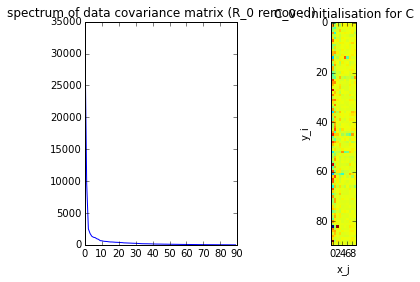

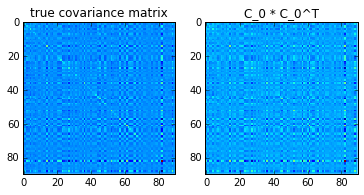

In [2]:
[initPars, initOptions] = ssm_fit._getInitPars(y, u, xDim, ifUseB, obsScheme, initC = 'PCA')

tmp =  ssm_fit._getResultsFirstEMCycle(initPars, obsScheme, y, u, eps=1e-30)
[Ext_0,Extxt_0,Extxtm1_0,LL_0,A_1,B_1,Q_1,mu0_1,V0_1,C_1,d_1,R_1,my,syy,suu,suuinv,Ti,Ext_1,Extxt1_1,Extxtm1_1,LL_1] = tmp

elapsed time for fitting is
352.58926224708557


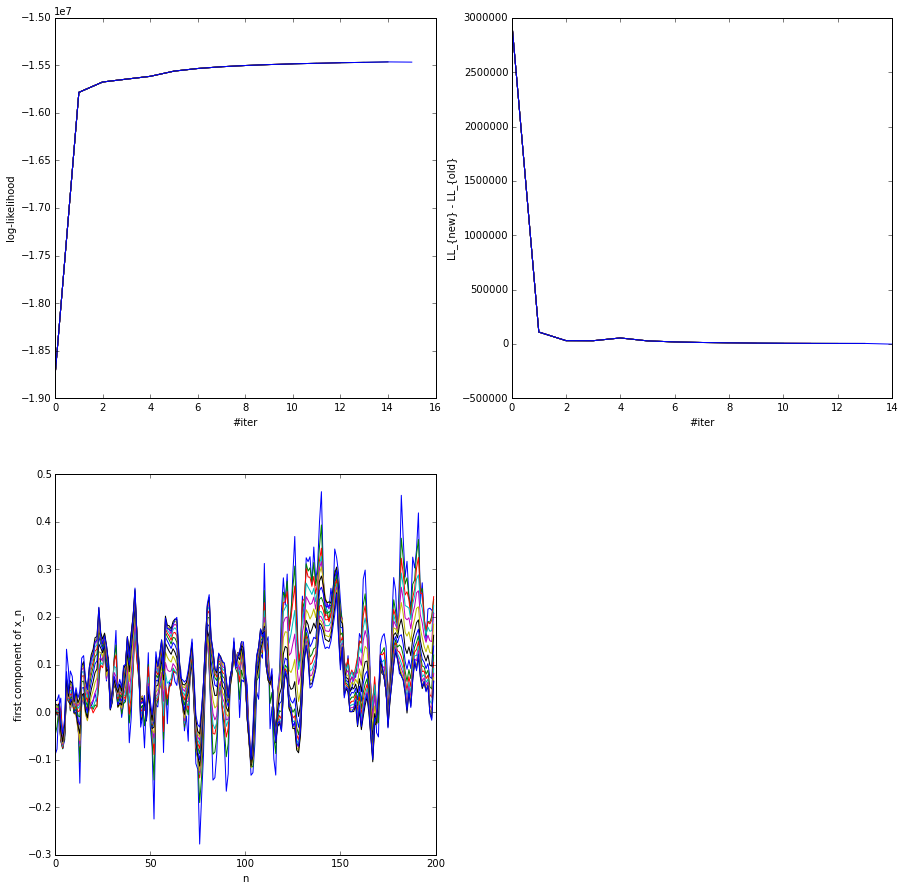

In [6]:
# fit the model to data                               

[A_0,B_0,Q_0,mu0_0,V0_0,C_0,d_0,R_0] = initPars
fitoptions = {'maxIter' : 50,
              'epsilon' : np.log(1.01),
              'ifPlotProgress' : True,
              'ifTraceParamHist' : False,
              'ifRDiagonal' : True,
              'ifUseB' : ifUseB,
              'covConvEps': 1e-30}

t = time.time()
%matplotlib inline

[[A_h],[B_h],[Q_h],[mu0_h],[V0_h],[C_h],[d_h],[R_h],LL] = ssm_fit._fitLDS(
            y, 
            u,
            obsScheme,
            initPars, 
            fitoptions,
            xDim)

elapsedTime = time.time() - t
print('elapsed time for fitting is')
print(elapsedTime)

if ifUseB:
    [Ext_h, Extxt_h, Extxtm1_h, LL_h]          = ssm_fit._LDS_E_step(A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h, 
                                                                     y,u,obsScheme, 1e-30)
else:
    [Ext_h, Extxt_h, Extxtm1_h, LL_h]          = ssm_fit._LDS_E_step(A_h,B_h,Q_h,mu0_h,V0_h,C_h,d_h,R_h, 
                                                                     y,None,obsScheme, 1e-30)
    

Pi_h    = np.array([sp.linalg.solve_discrete_lyapunov(A_h, Q_h)])[0,:,:]
Pi_t_h  = np.dot(A_h.transpose(), Pi_h)

In [20]:
np.zeros([0,1])

array([], shape=(0, 1), dtype=float64)

In [3]:
# save results for numerical comparison with Matlab-generated results
matlabSaveFile = {'x': x, 'y': y, 'u' : u, 
                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
                  'A_0':A_0, 'B_0':B_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'d_0':d_0,'R_0':R_0,
                  'A_1':A_1, 'B_1':B_1, 'Q_1':Q_1, 'mu0_1':mu0_1,'V0_1':V0_1,'C_1':C_1,'d_1':d_1,'R_1':R_1,
                  'A_h':A_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'d_h': d_h, 'R_h':R_h,
                  'Ext':Ext_0, 'Extxt':Extxt_0, 'Extxtm1':Extxtm1_0,
                  'T':T,
                  'LL0': LL_0, 'LL1': LL_1}
savemat('LDS_data.mat',matlabSaveFile)


NameError: name 'A_0' is not defined

In [7]:
# save results for visualisation (with Matlab code, as my python-plotting still lacks badly)
if u is None:
    u = 0
matlabSaveFile = {'x': x, 'y': y, 'u' : u, 'LL' : LL,
                  'ifDataGeneratedWithInput' : ifDataGeneratedWithInput, 
                  'ifInputPiecewiseConstant' : ifInputPiecewiseConstant,
                  'constantInputLength' : constantInputLength,
                  'ifUseB':ifUseB,
                  'A':A, 'B':B, 'Q':Q, 'mu0':mu0,'V0':V0,'C':C,'d':d,'R':R,
                  'A_0':A_0, 'B_0':B_0, 'Q_0':Q_0, 'mu0_0':mu0_0,'V0_0':V0_0,'C_0':C_0,'d_0':d_0, 'R_0':R_0,
                  'A_h':A_h, 'B_h':B_h, 'Q_h':Q_h, 'mu0_h':mu0_h,'V0_h':V0_h,'C_h':C_h,'d_h':d_h, 'R_h':R_h,
                  'Ext_h':Ext_h, 'Extxt_h':Extxt_h, 'Extxtm1_h':Extxtm1_h,
                  'Ext_true':Ext_true, 'Extxt_true':Extxt_true, 'Extxtm1':Extxtm1_true,
                  'Pi' : Pi, 'Pi_h' : Pi_h, 'Pi_t' : Pi_t, 'Pi_t_h': Pi_t_h,
                  'obsScheme' : obsScheme}
savemat('LDS_data_to_visualise.mat',matlabSaveFile)


In [3]:
import pickle as pickle
x = pickle.load(open('/home/mackelab/Desktop/spiketimes_e.p','rb'))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xbb in position 0: ordinal not in range(128)